* 신경망 이전에는 사람이 생각한 특징을 이미지에서 벡터로 변환했고, 그래서 문제에 적합한 특징을 쓰지 않으면 좋은 결과가 안나왔다
* 신경망은 특징 선정까지 알아서 해결!

### 4.1 Loss fcts

In [4]:
import numpy as np

*SSE의 원래 식에서 $1/2$이 추가된건 Gaussian MLE 식에 기반한 테크닉*

In [3]:
# sum of squares for error, SSE
def sum_squares_error(y, t):
  return 0.5 * np.sum((y-t)**2)

y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

# 작은 sse 값일 수록 정답에 가까움
sum_squares_error(np.array(y), np.array(t))

0.09750000000000003

In [1]:
# cross entropy error, CEE
# 0에 가까운 CEE일 수록 정답, 게산에서 정답 인덱스만 신경쓴다
def cross_entropy_error(y, t):
  delta = 1e-7
  return -np.sum(t * np.log(y + delta))

In [5]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

In [6]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

2.302584092994546

미니배치 학습
* 전체 훈련 데이터에 대해 손실함수를 최소화로 만드는 매개변수를 찾아야 한다
$$E = -\frac{1}{N} \sum_n \sum_k t_{nk} \log y_{nk}$$
  * N으로 나눔으로써 loss값을 한 데이터에서 나온 loss값과 비슷하게 정규화(평균손실함수)
* 평균손실함수는 데이터 개수와 관계없이 언제든 통일된 지표 가능

In [9]:
# 훈련 데이터에서 지정한 수의 데이터를 무작위로 골라내기
from tensorflow.keras.datasets import mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

# one-hot-encoding
def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1

    return T

t_train = _change_one_hot_label(t_train)
t_test = _change_one_hot_label(t_test)

print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(60000, 28, 28)
(60000, 10)
(10000, 28, 28)
(10000, 10)


In [11]:
train_size = x_train.shape[0]
batch_size = 10

batch_mask = np.random.choice(train_size, batch_size)

x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [12]:
# for batch
def cross_entropy_error(y, t):
  if y.ndim() == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)
  batch_size = y.shape[0]
  return -np.sum(t*np.log(y + 1e-7)) / batch_size

# for batch, not one-hot-encoded label
def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  batch_size = y.shape[0]
  return -np.sum(np.log(y[np.arange(batch_size)] + 1e-7)) / batch_size



정확도라는 지표 대신 손실함수의 값을 사용하는 이유는?
* 신경망 학습은 손실 함수의 값을 가능한 작게 하는 매개변수를 gradient descent로 찾는다   
  하지만 **정확도를 지표로 삼으면 매개변수의 미분이 대부분의 장소에서 0**이 된다
  * 매개변수의 값을 조금 바꿔도 정확도는 바뀌지 않고 그대로 유지될 것이기 때문
  * 게다가 정확도는 100개중에 몇개를 맞느냐를 말하기 때문에 이산적인 수치만 가능하다




## 4.3 수치 미분


* 미분을 구현할 때 미소 변화를 10e-50과 같은 숫자로 연산하면 rounding error가 발생한다.   
 즉, 우리가 하고 싶은 아주 조그마한 연산이 무시된다.

In [13]:
np.float32(10e-50)

0.0

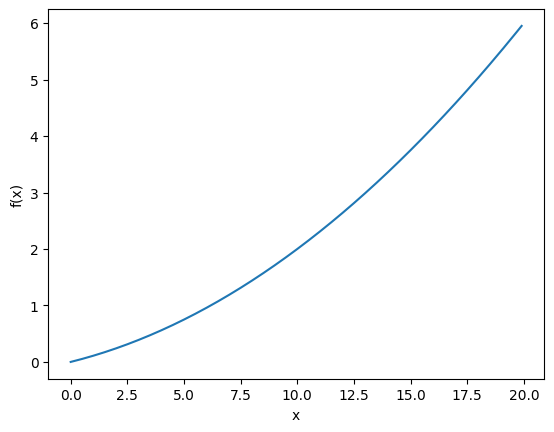

In [19]:
# finite differencing
def numerical_dif(f, x):
  h = 1e-4
  return (f(x+h)-f(x-h)) / (2*h)

def function_1(x):
  return 0.01 * x**2 + 0.1 * x

import matplotlib.pylab as plt

x = np.arange(0., 20., 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

In [21]:
print(numerical_dif(function_1, 5))
print(numerical_dif(function_1, 10))

0.1999999999990898
0.2999999999986347


In [22]:
def function_2(x):
  return x[0]**2 + x[1]**2

In [23]:
def numerical_gradient(f, x):
  h = 1e-4
  grad = np.zeros_like(x)

  for idx in range(x.size):
    tmp_val = x[idx]
    # f(x+h)
    x[idx] = tmp_val + h
    fxh1 = f(x)

    # f(x-h)
    x[idx] = tmp_val - h
    fxh2 = f(x)

    grad[idx] = (fxh1 - fxh2) / (2 * h)
    x[idx] = tmp_val

  return grad

In [26]:
print(numerical_gradient(function_2, np.array([3., 4.])))
print(numerical_gradient(function_2, np.array([0., 2.])))
print(numerical_gradient(function_2, np.array([3., 0.])))

[6. 8.]
[0. 4.]
[6. 0.]


* -gradient는 가장 낮은 장소를 가리키는 벡터다

In [27]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
  x = init_x

  for i in range(step_num):
    x -= lr * numerical_gradient(f, x)

  return x

In [29]:
init_x = np.array([-3., 4.])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

In [30]:
import numpy as np

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val # 값 복원
        it.iternext()

    return grad

class simpleNet:
  def __init__(self):
    self.W = np.random.randn(2,3)

  def predict(self, x):
    return np.dot(x, self.W)

  def loss(self, x, t):
    z = self.predict(x)
    y = softmax(z)
    loss = cross_entropy_error(y, t)

    return loss

In [40]:
net = simpleNet()
print(net.W)

x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

np.argmax(p)

t = np.array([0, 0, 1])
net.loss(x, t)

[[-0.04392477  2.05967759 -0.03722715]
 [-0.57746205  0.59156448  0.79478428]]
[-0.5460707   1.76821458  0.69296956]


1.4399230874182691

In [41]:
def f(W):
  return net.loss(x, t)

dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.04118053  0.41665175 -0.45783228]
 [ 0.06177079  0.62497763 -0.68674842]]


## 4.5 학습 알고리즘 구현하기
* 데이터를 미니배치로 무작위로 선정한다 -> SGD

In [42]:
# common/functions.py
import numpy as np

def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)


def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad


def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

In [43]:
class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    self.params = {}
    self.params['W1'] = weight_init_std * \
                        np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * \
                        np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def predict(self, x):
    W1, W2 = self.params['W1'], self.params['W2']
    b1, b2 = self.params['b1'], self.params['b2']

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)

    return y

  def loss(self, x, t):
    y = self.predict(x)

    return cross_entropy_error(y, t)

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    t = np.argmax(t, axis=1)

    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy

  def numerical_gradient(self, x, t):
    loss_W = lambda W: self.loss(x, t)

    grads = {}
    grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

    return grads


In [44]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)


(784, 100)
(100,)
(100, 10)
(10,)


In [45]:
x = np.random.rand(100, 784)
y = net.predict(x)

In [48]:
x = np.random.rand(100, 784)
t = np.random.rand(100, 10)

grads = net.numerical_gradient(x, t)

print(grads['W1'].shape)
print(grads['b1'].shape)
print(grads['W2'].shape)
print(grads['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [56]:
from tensorflow.keras.datasets import mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

# one-hot-encoding
def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1

    return T

x_train = x_train.reshape(60000, -1)
t_train = _change_one_hot_label(t_train)
x_test = x_test.reshape(10000, -1)
t_test = _change_one_hot_label(t_test)


print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


In [57]:
train_loss_list = []


iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  # 기울기 계산
  grad = network.numerical_gradient(x_batch, t_batch)

  # 매개변수 갱신
  for key in ('W1', 'b1', 'W2', 'b2'):
    network.params[key] -= learning_rate * grad[key]

  # 학습 경과 기록
  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

KeyboardInterrupt: 

* epoch은 학습에서 훈련 데이터를 모두 소진했을 때의 횟수에 해당한다   
  10000개 훈련데이터를 100개의 미니배치로 학습할 경우, SGD 100회 반복하면 1epoch